# Subscription in Welt

## Preparation

In [8]:
import pandas as pd
%pylab inline

# date handling
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

Populating the interactive namespace from numpy and matplotlib


## Load Data

In [9]:
# Main infos on subscriptions
product_owner = pd.read_csv("../data/SSOID_Produktbesitze.CSV", encoding = 'latin-1', 
                            parse_dates = ['VB_Tag','VE_Tag'], date_parser = dateparse)
# Info on cancellation
abo_canc = pd.read_csv("../data/SSOID_CancDatum.CSV", encoding = 'latin-1', date_parser = dateparse, parse_dates=["K Tag"])

### Some Merging & data filtering

Nur bestimmte Abo-Arten (WeltPlus, WeltGold, WeltPremium) und Vertragsstatus 'Vollabo' wird betrachtet.
Berechne Vertragslänge: VE_Tag - VB_Tag

In [7]:
# merge product_owner with subscription cancellation by SSO-ID, VT Transcactions-ID to get date of cancellation
# some duplicates
product_owner_canc = pd.merge(product_owner, abo_canc, on=['KD SSO-ID', 'VT Transaction ID'])
product_owner_canc = product_owner_canc.drop_duplicates(['KD SSO-ID', 'VT Transaction ID'], keep='last')

# long subsriptions (WeltPlus, WeltPremium, WeltGold ) + Vollabo
po_longSubs = product_owner.loc[((product_owner['Promotion_ID'] == 10003002) & (product_owner['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner['Promotion_ID'] == 10003006) & (product_owner['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner['Promotion_ID'] == 10003011) & (product_owner['Vertragsphase'] == 'Vollabo'))].copy()

# long subsriptions (WeltPlus, WeltPremium, WeltGold ) + Vollabo + Kündigungsdatum
po_longSubs_canc = product_owner_canc.loc[((product_owner_canc['Promotion_ID'] == 10003002) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner_canc['Promotion_ID'] == 10003006) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner_canc['Promotion_ID'] == 10003011) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))].copy()

po_longSubs_canc['Vertragslaenge'] =  (po_longSubs_canc['VE_Tag'] - po_longSubs_canc['VB_Tag']) / np.timedelta64(1, 'D')

## Vertragslängen

count    7749.000000
mean       97.603691
std        69.924465
min        28.000000
25%        58.000000
50%        61.000000
75%       121.000000
max       456.000000
Name: Vertragslaenge, dtype: float64


[Text(0,0.5,'Anzahl der Abos'), Text(0.5,0,'Länge der Abos in Tagen')]

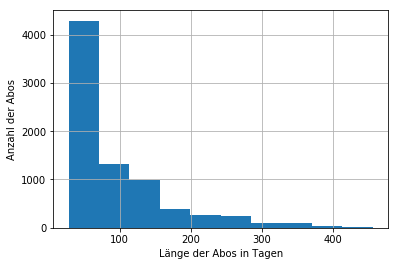

In [10]:
print(po_longSubs_canc['Vertragslaenge'].describe())
pt = po_longSubs_canc['Vertragslaenge'].hist()
pt.set(xlabel='Länge der Abos in Tagen',
       ylabel='Anzahl der Abos')

In [11]:
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 1 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=31)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 2 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=62)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 3 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=92)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 4 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=124)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 5 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=155)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 6 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=186)/7749*100)+'%')

Prozent der langfristigen Abos mit Laufzeit von bis zu 1 Monaten:
0.50%

Prozent der langfristigen Abos mit Laufzeit von bis zu 2 Monaten:
53.88%

Prozent der langfristigen Abos mit Laufzeit von bis zu 3 Monaten:
70.05%

Prozent der langfristigen Abos mit Laufzeit von bis zu 4 Monaten:
79.31%

Prozent der langfristigen Abos mit Laufzeit von bis zu 5 Monaten:
85.25%

Prozent der langfristigen Abos mit Laufzeit von bis zu 6 Monaten:
89.59%


### Vertragslängen in Gruppen: 2 (54%), 4 (25%), >4 Monate(21%)

In [12]:
# make column which labels different contract lengths
# Gruppe 1: Vertragslänge 2 Monate (~ 54%)
# Gruppe 2: Vertragslänge 4 Monate (~ 25%)
# Gruppe 3: Vertragslänge > 4 Monate (~ 21%)
po_longSubs_canc['Vertragslaenge_Gruppe'] = "Gr3"
po_longSubs_canc.loc[po_longSubs_canc['Vertragslaenge'] <= 124, 'Vertragslaenge_Gruppe' ] ="Gr2"
po_longSubs_canc.loc[po_longSubs_canc['Vertragslaenge'] <= 62, 'Vertragslaenge_Gruppe' ] ="Gr1"

## Kündigungsgründe

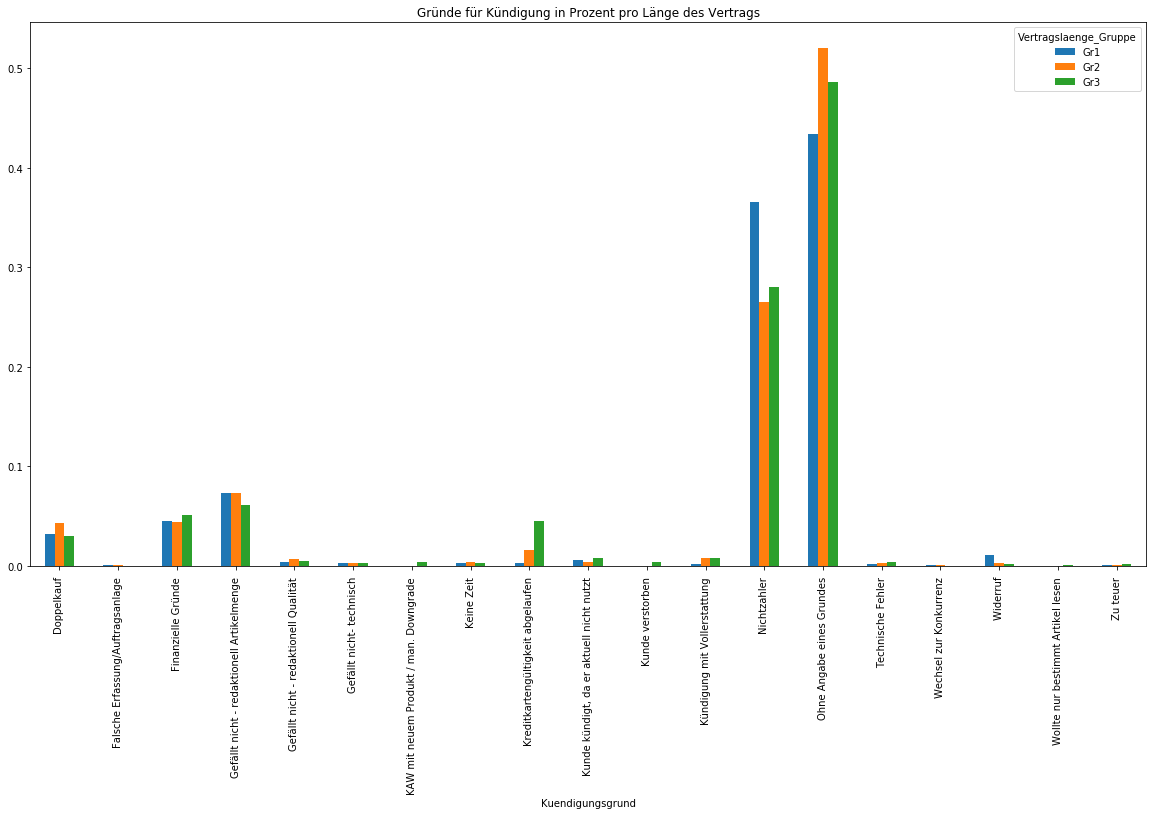

In [15]:
po_longSubs_cancReas_count = po_longSubs_canc.groupby(['Kuendigungsgrund','Vertragslaenge_Gruppe'])['KD SSO-ID'].count()
po_longSubs_promo = po_longSubs_canc.groupby('Vertragslaenge_Gruppe')['KD SSO-ID'].count()
po_longSubs_cancReas_perc = po_longSubs_cancReas_count.div(po_longSubs_promo, level='Vertragslaenge_Gruppe')

po_longSubs_cancReas_perc.unstack().plot(kind='bar', figsize=(20,10), title= "Gründe für Kündigung in Prozent pro Länge des Vertrags")

In [ ]:
Ein Großteil der Abos werden nach 2 Monaten gekündigt mit dem Grund "Nichtzahler". Falsche Zahlungsdetails hinterlegt? 

Bei langfristigen Abos laufen die Kreditkarten ab.